### 1. Importation des packages nécessaires

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from shapely.ops import unary_union
import os
import glob2

### 2. Préparation des couches fixes

In [2]:
# France métropolitaine

world = gpd.read_file("country_france/ne_110m_admin_0_countries.shp") # Charger les fichiers du monde
france = world[world['ADMIN'] == 'France'] # Filtrage de la France
france_exploded = france.explode(index_parts=False) # Eclatement du polygone de la France en plusieurs
france_exploded_proj = france_exploded.to_crs(epsg=2154) # Projection des géométries (en mètres)
france_exploded_proj['area'] = france_exploded_proj.geometry.area # Calcul de l'aire
france_metropole = france_exploded_proj.sort_values('area', ascending=False).iloc[[0]] # sélection de la géométrie la plus vaste
union_geom = unary_union(france_metropole.geometry) # Unir les géométries

# Communes
communes = gpd.read_file("shapefile_commune/COMMUNE.shp")
communes_proj = communes.to_crs(epsg=2154)
communes_proj_simple = communes_proj[["geometry", "INSEE_COM"]]

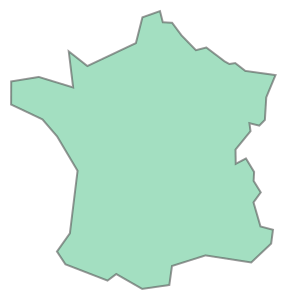

In [3]:
union_geom  # mettre la France métropolitaine en un seul bloc

In [4]:
communes_proj_simple

,geometry,INSEE_COM
0,"POLYGON ((808611.8 6647932.3, 808616.4 6647918...",71010
1,"POLYGON ((547061.5 6891568.6, 546950.5 6891830...",27658
2,"POLYGON ((855756.2 6944043.1, 855753 6944083.6...",08466
3,"POLYGON ((935224.3 6754155.9, 935148.1 6754011...",70017
4,"POLYGON ((917787.2 6532869.7, 917777.1 6532854...",01138
...,...,...
34811,"POLYGON ((576390.6 6687745.1, 576347.3 6687790...",41164
34812,"POLYGON ((688055.5 6909797.2, 688065.9 6909789...",60274
34813,"POLYGON ((730581.7 6825995.7, 730581.5 6825995...",77072
34814,"POLYGON ((536415.1 6431659.9, 536270.7 6431733...",24261


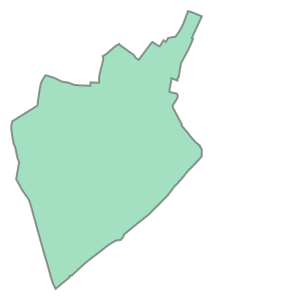

In [5]:
communes_proj_simple["geometry"][np.random.randint(0,len(communes_proj_simple))] # Représentation d'un polygône associé à une commune

In [6]:
len(communes_proj_simple)

34816

### 3. Attribution d'une commune à chaque ligne un CSV

In [7]:
df_vent_2012_01 = pd.read_csv("vent_2012_01.csv", parse_dates=['time']) 
    
# Création des points géographiques
gdf_01_2012 = gpd.GeoDataFrame(df_vent_2012_01, geometry=gpd.points_from_xy(df_vent_2012_01.longitude, df_vent_2012_01.latitude), crs="EPSG:4326") 
gdf_01_2012 = gdf_01_2012.to_crs(epsg=2154)  # Projection en EPSG:2154
gdf_01_2012_france = gdf_01_2012[gdf_01_2012.geometry.within(union_geom)] # Sélectionner que les points qui sont uniquement dans l'hexagone

In [8]:
gdf_01_2012_france.head(5)

,time,latitude,longitude,u10,v10,u100,v100,u10n,v10n,gust,wind_speed_10m,wind_speed_100m,wind_speed_10m_neutral,geometry
152,2012-01-01,51.00,2.00,7.001434,5.614212,10.906296,8.059616,6.961929,5.582504,14.310605,8.974378,13.561147,8.923722,POINT (629650.134 7100910.055)
153,2012-01-01,51.00,2.25,6.325653,4.808548,10.362350,7.256882,6.272476,4.769028,13.580136,7.945818,12.650717,7.879567,POINT (647236.984 7100715.164)
154,2012-01-01,51.00,2.50,5.784637,4.151321,9.882858,6.508835,5.689468,4.083481,12.466855,7.120078,11.833673,7.003204,POINT (664824.362 7100575.954)
212,2012-01-01,50.75,1.75,6.423309,5.306595,10.439499,7.795944,6.406265,5.292465,13.995175,8.331798,13.029194,8.309658,POINT (611622.855 7073296.477)
213,2012-01-01,50.75,2.00,5.894989,4.452103,9.853561,6.803757,5.872086,4.435043,12.944394,7.387294,11.974297,7.358736,POINT (629297.221 7073044.649)


#### *Représentation des points de mesures et des communes de France*


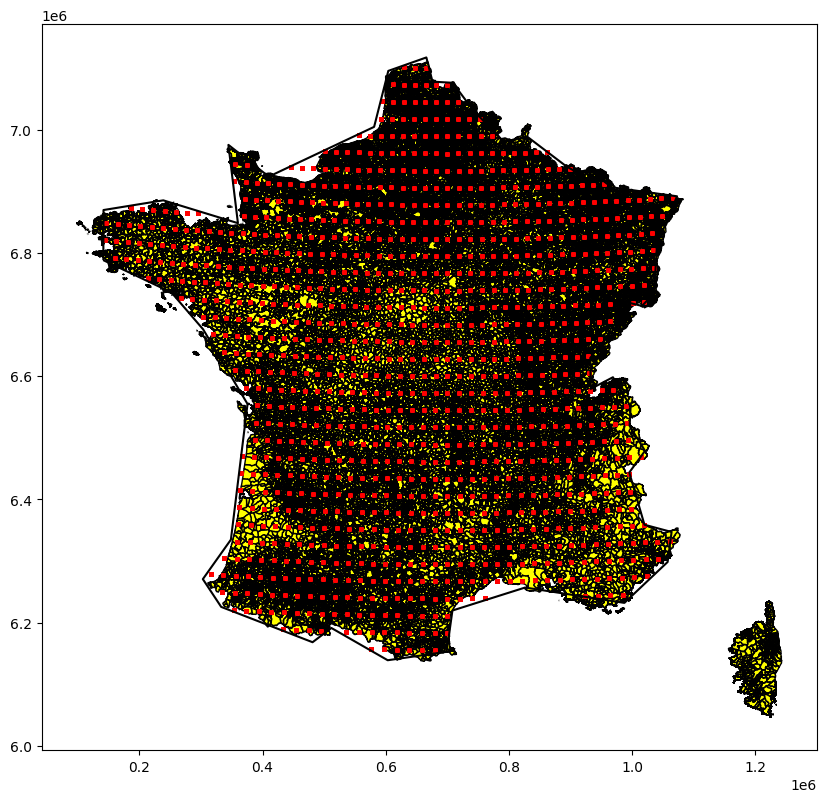

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))
france_metropole.boundary.plot(ax=ax, color='black')  # Tracer la frontière de la France
communes_proj_simple.plot(ax=ax, color='yellow', edgecolor='black')  # Tracer les communes
gdf_01_2012_france.plot(ax=ax, color='red', markersize=5)  # Tracer les points de mésure
plt.show()

##### *Les stations de mésures sont réparties sur la quasi-totalité du térritoire de la France métropolitaine. Etant donné qu'il y a 0.25° de longitude entre de points de mésures, nous avons 27.75 km entre deux points rouges sur la carte. On constate aussi que certaines communes sont très petites au point de ne pas être parfaitment aperçues dans les surfaces noires.*

#### *Création de la fonction pour attribuer les communes à chaque ligne d'un csv et faire des agrégations*

In [10]:
def process_and_aggregate(csv_file_path, communes_proj_simple, union_geom):
    """
    Cette fonction fait l'attribution des communes puis agrège les lignes par jour et commune.
    : csv_file_path: Chemin d'accès du csv contenant les données sur les vents.
    : communes_proj_simple: GeoDataFrame contenant les géométries (polygones) des communes.
    : union_geom: Polygone de la France pour réaliser des filtres.
    : return: DataFrame agrégé par jour et commune.
    
    """
    
    # Attribution des communes
    df_vent = pd.read_csv(csv_file_path, parse_dates=['time']) 
    gdf = gpd.GeoDataFrame(df_vent, geometry=gpd.points_from_xy(df_vent.longitude, df_vent.latitude), crs="EPSG:4326") 
    gdf = gdf.to_crs(epsg=2154)  

    gdf_france = gdf[gdf.within(union_geom)] 
    communes_buffered = communes_proj_simple.copy()
    communes_buffered['geometry'] = communes_buffered.geometry.buffer(14000)  

    gdf_france_exact = gpd.sjoin(gdf_france, communes_buffered, how="right", predicate="within") 
    gdf_france_exact = gdf_france_exact.dropna()

    gdf_final = gdf_france_exact.drop(columns=[col for col in ["geometry", "index_right"] if col in gdf_france_exact.columns]) 

    # Agrégation des données
    gdf_final['time'] =  gdf_final['time'].astype(str).str.replace('time', '')
    gdf_final['time'] = pd.to_datetime(gdf_final['time'], format='%Y-%m-%d %H:%M:%S', errors = 'coerce')
    result = gdf_final.groupby(['INSEE_COM', gdf_final['time'].dt.date]).agg({
        'wind_speed_10m': ['mean', 'max', 'min', 'std'],
        'wind_speed_100m': ['mean', 'max', 'min', 'std'],
        'wind_speed_10m_neutral': ['mean', 'max', 'min', 'std'],
        'gust': ['mean', 'max', 'min', 'std']
    }).reset_index()

    result.columns = ['INSEE_COM', 'date', 
                      'wind_speed_10m_mean', 'wind_speed_10m_max', 'wind_speed_10m_min', 'wind_speed_10m_std',
                      'wind_speed_100m_mean', 'wind_speed_100m_max', 'wind_speed_100m_min', 'wind_speed_100m_std',
                      'wind_speed_10m_neutral_mean', 'wind_speed_10m_neutral_max', 'wind_speed_10m_neutral_min', 'wind_speed_10m_neutral_std',
                      'gust_mean', 'gust_max', 'gust_min', 'gust_std']

    return result

In [11]:
process_and_aggregate("vent_2012_01.csv",communes_proj_simple, union_geom)

,INSEE_COM,date,wind_speed_10m_mean,wind_speed_10m_max,wind_speed_10m_min,wind_speed_10m_std,wind_speed_100m_mean,wind_speed_100m_max,wind_speed_100m_min,wind_speed_100m_std,wind_speed_10m_neutral_mean,wind_speed_10m_neutral_max,wind_speed_10m_neutral_min,wind_speed_10m_neutral_std,gust_mean,gust_max,gust_min,gust_std
0,01001,2012-01-01,2.913699,4.400626,1.992634,0.518392,5.918468,8.787235,3.638927,1.140085,2.766286,4.207249,1.836478,0.506258,6.284210,8.887487,5.278975,0.762055
1,01001,2012-01-02,3.466270,6.052163,1.320210,1.704118,6.778924,10.563096,2.934019,2.634240,3.221532,5.956607,0.683192,1.835547,7.378092,12.461085,2.729614,3.484016
2,01001,2012-01-03,3.756144,5.828981,0.885890,1.607492,6.659769,10.125299,1.454625,2.635571,3.572213,5.795269,0.269263,1.856979,7.758114,11.860596,1.827097,3.441912
3,01001,2012-01-04,3.892766,6.503185,1.073979,1.408350,6.818870,11.241844,2.667719,2.262378,3.801390,6.436276,0.770253,1.474768,7.798929,13.996494,2.400083,3.287759
4,01001,2012-01-05,5.515813,8.936946,3.847330,1.309389,9.538222,14.621716,6.771683,2.065817,5.449158,8.880027,3.789630,1.300695,12.083462,19.660385,7.825765,3.108049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1046090,95690,2012-01-27,2.482446,3.345590,1.914522,0.422788,5.199470,7.269465,3.162205,1.042786,2.185156,3.395457,1.232518,0.605750,4.974872,6.773707,3.375495,0.850784
1046091,95690,2012-01-28,2.352340,3.313956,1.643597,0.404513,4.424668,5.705543,2.299108,0.923956,2.232237,3.334998,1.371623,0.455847,5.035251,7.205882,3.470629,0.989961
1046092,95690,2012-01-29,3.306543,4.225039,2.095005,0.522620,5.017963,6.585174,2.865182,0.842141,3.342353,4.358154,2.142658,0.572822,6.348448,8.854163,4.616137,1.163595
1046093,95690,2012-01-30,1.401934,2.894332,0.380486,0.829742,1.882697,4.137278,0.442279,1.265373,1.501073,2.912471,0.493722,0.773050,3.238894,5.859472,1.859408,1.149584


#### *Application de la fonction sur les csv*

In [12]:
dir_path = "01_csv_2012_2025/csv_2012_2016"
liste_csv = glob2.glob(os.path.join(dir_path, "*.csv"))

# Charger les fichiers traités depuis la log
log_file_path = "processed_files.log"
if os.path.exists(log_file_path):
    with open(log_file_path, 'r') as log_file:
        processed_files = log_file.read().splitlines()
else:
    processed_files = []

# Traitement de chaque fichier
for fichier in liste_csv:
    if fichier in processed_files:
        print(f"Déjà traité : {fichier}")
        continue
    
    print(f"Traitement de : {fichier}")
    try:
        resultat = process_and_aggregate(fichier, communes_proj_simple, union_geom)
        
        # Sauvegarde du fichier final
        mois = os.path.basename(fichier).replace(".csv", "")
        resultat.to_csv(f"resultats_{mois}.csv", index=False)

        # Chargé les fichiers déjà traités
        with open(log_file_path, 'a') as log_file:
            log_file.write(fichier + '\n')

        # Libération de la mémoire
        del resultat

    except Exception as e:
        print(f"Erreur avec {fichier} : {e}")  

Déjà traité : 01_csv_2012_2025/csv_2012_2016\vent_2012_01.csv
Déjà traité : 01_csv_2012_2025/csv_2012_2016\vent_2012_02.csv
Déjà traité : 01_csv_2012_2025/csv_2012_2016\vent_2012_03.csv
Déjà traité : 01_csv_2012_2025/csv_2012_2016\vent_2012_04.csv
Déjà traité : 01_csv_2012_2025/csv_2012_2016\vent_2012_05.csv
Déjà traité : 01_csv_2012_2025/csv_2012_2016\vent_2012_06.csv
Déjà traité : 01_csv_2012_2025/csv_2012_2016\vent_2012_07.csv
Déjà traité : 01_csv_2012_2025/csv_2012_2016\vent_2012_08.csv
Déjà traité : 01_csv_2012_2025/csv_2012_2016\vent_2012_09.csv
Déjà traité : 01_csv_2012_2025/csv_2012_2016\vent_2012_10.csv
Déjà traité : 01_csv_2012_2025/csv_2012_2016\vent_2012_11.csv
Déjà traité : 01_csv_2012_2025/csv_2012_2016\vent_2012_12.csv
Déjà traité : 01_csv_2012_2025/csv_2012_2016\vent_2013_01.csv
Déjà traité : 01_csv_2012_2025/csv_2012_2016\vent_2013_02.csv
Déjà traité : 01_csv_2012_2025/csv_2012_2016\vent_2013_03.csv
Déjà traité : 01_csv_2012_2025/csv_2012_2016\vent_2013_04.csv
Déjà tra

In [13]:
dir_path = "01_csv_2012_2025/csv_2017_2021"
liste_csv = glob2.glob(os.path.join(dir_path, "*.csv"))

# Charger les fichiers traités depuis la log
log_file_path = "processed_files.log"
if os.path.exists(log_file_path):
    with open(log_file_path, 'r') as log_file:
        processed_files = log_file.read().splitlines()
else:
    processed_files = []

# Traitement de chaque fichier
for fichier in liste_csv:
    if fichier in processed_files:
        print(f"Déjà traité : {fichier}")
        continue
    
    print(f"Traitement de : {fichier}")
    try:
        resultat = process_and_aggregate(fichier, communes_proj_simple, union_geom)
        
        # Sauvegarde du fichier final
        mois = os.path.basename(fichier).replace(".csv", "")
        resultat.to_csv(f"resultats_{mois}.csv", index=False)

        # Chargé les fichiers déjà traités
        with open(log_file_path, 'a') as log_file:
            log_file.write(fichier + '\n')

        # Libération de la mémoire
        del resultat

    except Exception as e:
        print(f"Erreur avec {fichier} : {e}")  

Déjà traité : 01_csv_2012_2025/csv_2017_2021\vent_2017_01.csv
Déjà traité : 01_csv_2012_2025/csv_2017_2021\vent_2017_02.csv
Déjà traité : 01_csv_2012_2025/csv_2017_2021\vent_2017_03.csv
Déjà traité : 01_csv_2012_2025/csv_2017_2021\vent_2017_04.csv
Déjà traité : 01_csv_2012_2025/csv_2017_2021\vent_2017_05.csv
Déjà traité : 01_csv_2012_2025/csv_2017_2021\vent_2017_06.csv
Déjà traité : 01_csv_2012_2025/csv_2017_2021\vent_2017_07.csv
Déjà traité : 01_csv_2012_2025/csv_2017_2021\vent_2017_08.csv
Déjà traité : 01_csv_2012_2025/csv_2017_2021\vent_2017_09.csv
Déjà traité : 01_csv_2012_2025/csv_2017_2021\vent_2017_10.csv
Déjà traité : 01_csv_2012_2025/csv_2017_2021\vent_2017_11.csv
Déjà traité : 01_csv_2012_2025/csv_2017_2021\vent_2017_12.csv
Déjà traité : 01_csv_2012_2025/csv_2017_2021\vent_2018_01.csv
Déjà traité : 01_csv_2012_2025/csv_2017_2021\vent_2018_02.csv
Déjà traité : 01_csv_2012_2025/csv_2017_2021\vent_2018_03.csv
Déjà traité : 01_csv_2012_2025/csv_2017_2021\vent_2018_04.csv
Déjà tra

In [14]:
dir_path = "01_csv_2012_2025/csv_2022_2025"
liste_csv = glob2.glob(os.path.join(dir_path, "*.csv"))

# Charger les fichiers traités depuis la log
log_file_path = "processed_files.log"
if os.path.exists(log_file_path):
    with open(log_file_path, 'r') as log_file:
        processed_files = log_file.read().splitlines()
else:
    processed_files = []

# Traitement de chaque fichier
for fichier in liste_csv:
    if fichier in processed_files:
        print(f"Déjà traité : {fichier}")
        continue
    
    print(f"Traitement de : {fichier}")
    try:
        resultat = process_and_aggregate(fichier, communes_proj_simple, union_geom)
        
        # Sauvegarde du fichier final
        mois = os.path.basename(fichier).replace(".csv", "")
        resultat.to_csv(f"resultats_{mois}.csv", index=False)

        # Chargé les fichiers déjà traités
        with open(log_file_path, 'a') as log_file:
            log_file.write(fichier + '\n')

        # Libération de la mémoire
        del resultat

    except Exception as e:
        print(f"Erreur avec {fichier} : {e}")  

Déjà traité : 01_csv_2012_2025/csv_2022_2025\vent_2022_01.csv
Déjà traité : 01_csv_2012_2025/csv_2022_2025\vent_2022_02.csv
Déjà traité : 01_csv_2012_2025/csv_2022_2025\vent_2022_03.csv
Déjà traité : 01_csv_2012_2025/csv_2022_2025\vent_2022_04.csv
Déjà traité : 01_csv_2012_2025/csv_2022_2025\vent_2022_05.csv
Déjà traité : 01_csv_2012_2025/csv_2022_2025\vent_2022_06.csv
Déjà traité : 01_csv_2012_2025/csv_2022_2025\vent_2022_07.csv
Déjà traité : 01_csv_2012_2025/csv_2022_2025\vent_2022_08.csv
Déjà traité : 01_csv_2012_2025/csv_2022_2025\vent_2022_09.csv
Déjà traité : 01_csv_2012_2025/csv_2022_2025\vent_2022_10.csv
Déjà traité : 01_csv_2012_2025/csv_2022_2025\vent_2022_11.csv
Déjà traité : 01_csv_2012_2025/csv_2022_2025\vent_2022_12.csv
Déjà traité : 01_csv_2012_2025/csv_2022_2025\vent_2023_01.csv
Déjà traité : 01_csv_2012_2025/csv_2022_2025\vent_2023_02.csv
Déjà traité : 01_csv_2012_2025/csv_2022_2025\vent_2023_03.csv
Déjà traité : 01_csv_2012_2025/csv_2022_2025\vent_2023_04.csv
Déjà tra

Traitement de : 01_csv_2012_2025/csv_2022_2025\vent_2024_11.csv
Traitement de : 01_csv_2012_2025/csv_2022_2025\vent_2024_12.csv
Traitement de : 01_csv_2012_2025/csv_2022_2025\vent_2025_01.csv
Traitement de : 01_csv_2012_2025/csv_2022_2025\vent_2025_02.csv
Traitement de : 01_csv_2012_2025/csv_2022_2025\vent_2025_04.csv
Traitement de : 01_csv_2012_2025/csv_2022_2025\vent_2025_05.csv


In [23]:
test_vent = pd.read_csv("resultats_vent_2012_02.csv")

In [24]:
test_vent["INSEE_COM"].nunique()

33745